# Solution Methods for Microeconomic Dynamic Stochastic Optimization Problems (MicroDSOP)

- Author: Chris Carroll

This notebook is a companion to [SolvingMicroDSOPs](https://llorracc.github.io/SolvingMicroDSOPs/), providing executable Python code that implements the solution methods described in the corresponding lecture notes. It reproduces the key figures, demonstrates the algorithms section by section, and extends the treatment with a modular stage-based architecture for multi-control problems.

Each section of the notebook contains self-contained code corresponding to a section of the paper, so the reader can step through the material incrementally.


### Code–Math Concordance

| Math (LaTeX) | Python name | Module |
|---|---|---|
| $m, c, a, k$ | `mNrm`, `cNrm`, `aNrm`, `kNrm` | -- |
| $\mathrm{u}(\cdot)$ | `Utility` | `resources.py` |
| $\mathrm{v}_{\text{cntn}}$ | `Perch.v` at `cntn` | `solution.py` |
| $\mathrm{v}_{\text{cntn}}^{\partial}$ | `Perch.vδ` at `cntn` | `solution.py` |
| $\mathrm{c}_{\text{cntn}} \equiv (\mathrm{v}_{\text{cntn}}^{\partial})^{-1/\rho}$ | `Perch.cδ` at `cntn` | `solution.py` |
| $\beta, \rho, R$ | `DiscFac`, `CRRA`, `Rfree` | `ModelParams` |
| $\Gamma$ | `PermGroFac` | `ModelParams` |
| $\theta$ | `shock_nodes` | `portable.py` |
| $R / \Gamma$ | `params.RNrmByG` | `ModelParams` |
| $\varsigma$ | `Shr` | -- |
| Stage / Perch / Pile | `Stage`, `Perch`, `Pile` | `solution.py` |
| Connector | `Connector` | `solution.py` |
| Backward builder | `solve_one_period` | `period_types.py` |


In [1]:
from Code.Python.notebook_setup import *
from Code.Python.notebook_params import (
    base_params, make_income_distribution, natural_borrowing_constraint,
    portfolio_params, make_portfolio_distribution,
)
from Code.Python.notebook_solvers import (
    solve_Tm1_direct, solve_egm_Tm1, compute_uδ_vs_vCntnδ_data,
    solve_consumption_lifecycle, solve_portfolio_lifecycle,
    make_hark_portfolio_agent, evaluate_hark_marginal_values,
)
from Code.Python.endOfPrdMC import EndOfPrdMC
from Code.Python.resources import setup_grids_expMult, set_up_improved_EEE_a_grid

In [2]:
### HARK imports already included via notebook_setup

## Define Parameters, Grids, and the Utility Function 
Set up general parameters, as well as the first two major class instances: the utility function and the discrete approximation.

In [3]:
p = base_params()
rho, beta, Gamma, R, u = p['rho'], p['beta'], p['Gamma'], p['R'], p['u']
theta_sigma, theta_grid_N = p['theta_sigma'], p['theta_grid_N']
print(f"rho={rho}, beta={beta}, Gamma={Gamma}, R={R}")

rho=2.0, beta=0.96, Gamma=[1.], R=1.02


## Discretization of the Income Shock Distribution 

- See detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#discretizing-the-distribution)

In [4]:
theta = make_income_distribution(sigma=theta_sigma, N=theta_grid_N)
theta_mu = -0.5 * theta_sigma**2

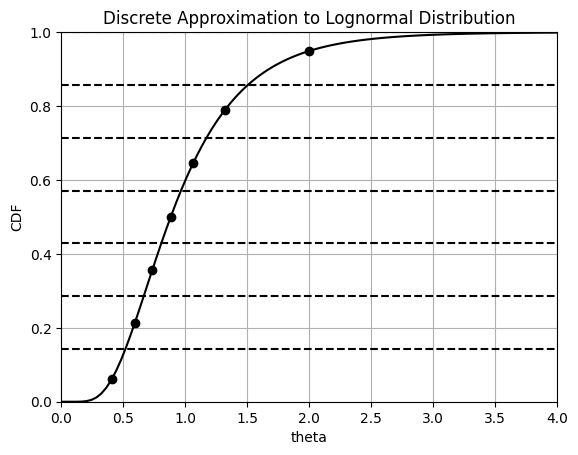

The distance between two adjacent horizontal dash lines represent the equiprobable bin.


In [5]:
#############################
## discreteapprox (equiprobable discrete approximation)
############################

x_min = theta_mu
x0 = 0.0
x1 = 4.0

theta.plot(x0, x1)

print(
    "The distance between two adjacent horizontal dash lines represent the equiprobable bin."
)

In [6]:
self_a_min = natural_borrowing_constraint(theta, Gamma, R)

## The EndOfPrd Class


The main code used to implement the solution can be found in the EndOfPrd class definition, which contains methods implementing the $\mathrm{v}_{\succ}$, $\grave{\mathrm{v}}_{\succ}$ (approximation of $\mathrm{v}_{\succ}$), $\mathrm{v}^{\partial}_{\succ}$, $\grave{\mathrm{v}}^{\partial}_{\succ}$, and $\mathrm{c}_{\succ}$, $\grave{\mathrm{c}}_{\succ}$ functions. These are essentially expectated value, expected marginal value, and expected marginal utility, respectively, as the functions of next-period value and consumption policy functions. 

Since these functions all involve computing expectations, we bundle them together as a EndOfPrd class and use an instance of the class below to solve a consumption function; this mirrors the treatment in [solving the next-to-last period](https://llorracc.github.io/SolvingMicroDSOPs/#solving-the-next) in the lecture notes.


#### Import and create instance of the EndOfPrd class

Create a particular instance of the EndOfPrd class, using $u$, $\beta$, $\rho$, $\Gamma$, and the $\theta$-approximation.  

In [7]:
from Code.Python.endOfPrd import EndOfPrd

endOfPrd = EndOfPrd(u, beta, rho, Gamma, R, theta)

## Solving the Model by Value Function Maximization

- See detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#the-approximate-consumption-and-value-functions)

First, we numerically maximize the value functions over a very fine set of grid points of the market resource (m) to get the benchmark solution to consumption policy and value function. We use it to approximate the "accurate" solution in this notebook. 

This approach will be improved in different ways in the sections below.

In [8]:
m_min, m_max, m_size = -0.1, 4.0, 5

# include some negative values

In [9]:
mVec_fine = np.linspace(m_min, m_max, 100)
cVec, vVec = solve_Tm1_direct(endOfPrd, mVec_fine)

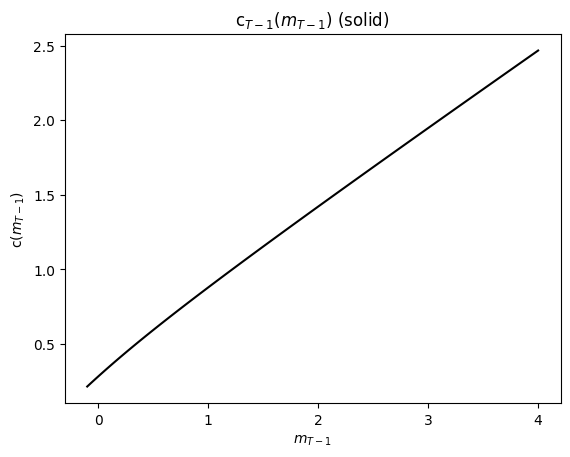

In [10]:
plot_consumption_Tm1(mVec_fine, cVec, save_as="cTm1Raw" if SAVE_FIGURES else None)


Then, solve the model with only a small number of grid points of m.

In [11]:
# very sparse m_grid

mVec = np.linspace(m_min, m_max, m_size)

In [ ]:
cVec0, vVec0 = solve_Tm1_direct(endOfPrd, mVec)
print(cVec0)

## An Interpolated Consumption Function

Although we have now solved optimal c above for a finite set of predetermined gridpoints of $m$, how do we know the consumption value at different values of $m$ not among these grid points? We need interpolation.

- See detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#an-interpolated-consumption-function)


The interpolated consumption function is not very different from the true consumption function. (See the figure *PlotcTm1Simple*.)

In [ ]:
cFunc0 = InterpolatedUnivariateSpline(mVec, cVec0, k=1)
mVec_int = np.linspace(0.0, 4.0, 50)
cVec_int = cFunc0(mVec_int)

plot_c_exact_vs_approx(mVec_fine, cVec, mVec_int, cVec_int, xlim_lo=self_a_min,
                      save_as="PlotcTm1Simple" if SAVE_FIGURES else None)


Does the interpolation of the value function work as well as that for consumption function?

It turns out that the interpolated value function only poorly approximates its true counterpart. (See the figure *PlotVTm1Simple*.) The reason for this is that value function is highly concave.

In [ ]:
vFunc0 = InterpolatedUnivariateSpline(mVec, vVec0, k=1)
vVec_int = vFunc0(mVec_int)

plot_v_exact_vs_approx(mVec_fine, vVec, mVec_int, vVec_int, xlim_lo=self_a_min,
                      save_as="PlotVTm1Simple" if SAVE_FIGURES else None)


## Interpolating Expectations

- See detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#interpolating-expectations)

The program above turns out to be __inefficient__. For every value of $m_{T −1}$ the program must calculate the utility consequences of various possible choices of $c_{T−1}$ as it searches for the best choice. But for any given value of $m_{T-1}-c_{T-1}=a_{T−1}$, there is a good chance that the program may end up calculating the corresponding v many times while maximizing utility from different $m_{T −1}$’s. 

An improvement can be made: we can construct a direct numerical approximation to the value function based on a vector of predefined $a=m-c$ grid and use the interpolated function to calculate $\mathrm{v}_{\succ,T-1}$ for a given $a$. 

In [ ]:
a_min, a_max, a_size = 0.0, 4.0, 5
aVec = np.linspace(a_min, a_max, a_size)

# Interpolated v_cntn on the coarse grid (the point of this section)
vEndPrdVec = np.array([endOfPrd.vEndPrd(a) for a in aVec])
vEndPrdFunc0 = InterpolatedUnivariateSpline(aVec, vEndPrdVec, k=1)

cVec1, vVec1 = solve_Tm1_direct(endOfPrd, mVec, v_cntn=vEndPrdFunc0)
print(cVec1)

The interpolated functions are of course identical at the gridpoints chosen for $a_{T− 1}$   and they appear reasonably close except in the region below $m_{T −1} = 1.0$. (See the figure *PlotOTm1RawVSInt*.)

In [ ]:
aVec_fine = np.linspace(a_min, a_max, 100)
vEndPrdVec_fine = np.array([endOfPrd.vEndPrd(a) for a in aVec_fine])

plot_vEndPrd_exact_vs_approx(aVec_fine, vEndPrdVec_fine, aVec, vEndPrdVec,
                            save_as="PlotOTm1RawVSInt" if SAVE_FIGURES else None)


Nevertheless, the resulting consumption rule obtained when $\grave{\mathrm{v}}_{\succ,T-1}(a_{T-1})$ is used instead of $\mathrm{v}_{\succ,T-1}(a_{T-1})$  is surprisingly bad. (See the figure *PlotComparecTm1AB*.)

In [ ]:
plot_c_from_vEndPrd(mVec_fine, cVec, mVec, cVec1,
                    save_as="PlotComparecTm1AB" if SAVE_FIGURES else None)


In [ ]:
##########################
### PlotuδVsvCntnδ (marginal utility vs marginal continuation value)
##########################
# u^{\partial}(c) vs v^{\partial}_cntn(m-c) and step-function v̂^{\partial}_cntn(m-c) for m=3, m=4.
# Uses σ_θ = 1.0 (exaggerated, matching Mathematica original) and a
# 5-point coarse grid to make the step-function visible.

uδ_vs_vCntnδ_data = compute_uδ_vs_vCntnδ_data()
plot_uδ_vs_vCntnδ(uδ_vs_vCntnδ_data,
                    save_as="Plot_ud_VS_vCntnd" if SAVE_FIGURES else None)

## Value Function versus the First Order Condition

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#value-function-versus-first-order-condition)

Our difficulty is caused by the fact that the consumption choice is governed by the marginal value function, not by the level of the value function (which is what we tried to approximate). 

At present we use the **approximated** marginal value function $\grave{\mathrm{v}}^{\partial}_{\succ}$ that we have just constructed in the prior figure. Consumption at each $m$ can be obtained by equating marginal utility to that approximation:

\begin{equation}
\mathrm{u}^{\partial}(\mathrm{c}_{T-1}(m_{T-1})) = \grave{\mathrm{v}}^{\partial}_{\succ}(m_{T-1}-\mathrm{c}_{T-1}(m_{T-1}))
\end{equation}

(In the next step we will improve further by finding the root of this first-order condition for every exogenously set $m$ grid.)

Now solve for consumption using FOCs instead of value function maximization. We use the **piecewise-linear approximation** $\grave{\mathrm{v}}^{\partial}_{\succ}$ to the marginal value function (built on the same $a$ grid as before), not the true $\mathrm{v}^{\partial}_{\succ}$.

In [ ]:
# Build piecewise-linear approximation to marginal value (same grid aVec as in the Interpolating Expectations section).
vpVec = [endOfPrd.vCntnδ_Tm1(a) for a in aVec]
vCntnδFunc = InterpolatedUnivariateSpline(aVec, vpVec, k=1)

In [ ]:
cVec2 = []  # Start with empty list.
for m in mVec:
    mintotwealth = m + Gamma[0] * theta.X[0] / R
    foc_condition = lambda c: u.δ(c) - vCntnδFunc(m - c)  # FOC with approx v'
    lo, hi = 1e-12, max(1e-12 + 1e-8, 0.999 * mintotwealth)
    try:
        c = brentq(foc_condition, lo, hi)
    except ValueError:
        fl, fh = foc_condition(lo), foc_condition(hi)
        c = hi if abs(fh) <= abs(fl) else lo
    cVec2.append(c)

print(cVec2)  # Look at the consumption from the list.

Plot the piecewise-linear approximation to the marginal value: exact $\mathrm{v}^{\partial}_{\succ,T-1}(a)$ (solid) versus $\grave{\mathrm{v}}^{\partial}_{\succ,T-1}(a)$ (dashed).

In [ ]:
aVec_fine = np.linspace(0.0001, 4, 1000)
vpVec_fine = [endOfPrd.vCntnδ_Tm1(a) for a in aVec_fine]

vpVec = [endOfPrd.vCntnδ_Tm1(a) for a in aVec]
vCntnδFunc = InterpolatedUnivariateSpline(aVec, vpVec, k=1)

plot_vp_exact_vs_approx(aVec_fine, vpVec_fine, aVec, vCntnδFunc(aVec),
                        save_as="PlotOPRawVSFOC" if SAVE_FIGURES else None)

The linear interpolating approximation looks roughly as good (or bad) for the marginal value function as it was for the level of the value function.

A revised version of the consumption comparison (*PlotComparecTm1AB*): the consumption function obtained by using **vCntnδFunc** (piecewise-linear marginal value) is shown together with the consumption from the approximated **value** function (dash-dot) and the true consumption function (solid).

In [ ]:
plot_c_three_methods(mVec_fine, cVec, mVec, cVec1, mVec, cVec2,
                     save_as="PlotcTm1ABC" if SAVE_FIGURES else None)


The new consumption function (long dashes) is a considerably better approximation of the true consumption function (solid) than was the consumption function obtained by approximating the level of the value function (short dashes). (See the figure *PlotcTm1ABC*.)

In [ ]:
# PlotcTm1ABC (three methods) is plotted above, after plot_vp_exact_vs_approx; it depicts c from vCntnδFunc (dashes), c from interpolated value (dash-dot), and true c (solid).


## Transformation

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#transformation)

However, even the new-and-improved consumption function diverges from the true solution, especially at lower values of m. That is because the linear interpolation does an increasingly poor job of capturing the nonlinearity of $\mathrm{v}^{\partial}_{T-1}(a_{T-1})$ at lower and lower levels of $a$.

To understand the trick that fixes this, consider the perfect-foresight case with $R/\Gamma = \beta = \Gamma = 1$ and certain income $\theta_T = 1$.  The Euler equation is $c_{T-1}^{-\rho} = c_T^{-\rho}$, and total resources include market wealth $m$ plus human wealth $h_{T-1} = 1$, giving a marginal value function

$$\mathrm{v}^{\partial}_{T-1}(m) = \left(\frac{m+1}{2}\right)^{-\rho}$$

which is highly nonlinear.  But raising both sides to $-1/\rho$ yields a *linear* function:

$$\left[\mathrm{v}^{\partial}_{T-1}(m)\right]^{-1/\rho} = \frac{m+1}{2}.$$

This is a general phenomenon: under perfect foresight with CRRA utility $c^{-\rho}$, the marginal value function always takes the form $(\gamma m + \zeta)^{-\rho}$, so raising to $-1/\rho$ always produces a linear function that can be interpolated exactly.

The key insight is that much of the nonlinearity in $\mathrm{v}^{\partial}$ comes from raising to the power $-\rho$.  By inverting that operation (raising to $-1/\rho$), we can "unwind" it, and the remaining nonlinearity is much smaller.  We therefore define an "inverse marginal value" function:

$$\left(\mathrm{v}^{\partial}_{\succ}(a)\right)^{-1/\rho}$$

and construct a piecewise-linear interpolation of *that* (nearly linear) function. For any $a$ in the grid range, the approximation of marginal value is recovered by raising the interpolated value back to $-\rho$:

$$\grave{\grave{\mathrm{v}}}^{\partial}(a) = \left[\grave{\left(\mathrm{v}^{\partial}_{\succ}\right)^{-1/\rho}}(a)\right]^{-\rho}.$$

#### The "consumed function" interpretation

The inverse marginal value function has a revealing economic interpretation. The first-order condition $\mathrm{u}^{\partial}(c) = \mathrm{v}^{\partial}_{\succ}(a)$ with CRRA utility gives $c^{-\rho} = \mathrm{v}^{\partial}_{\succ}(a)$, so

$$\mathrm{c}_{\succ}(a) = \left(\mathrm{v}^{\partial}_{\succ}(a)\right)^{-1/\rho}.$$

That is, $(\mathrm{v}^{\partial}_{\succ}(a))^{-1/\rho}$ tells us how much the agent must *have consumed* to optimally arrive at end-of-period assets $a$.  We call this the **consumed function** $\mathrm{c}_{\succ}(a)$.  It is the same object we are interpolating — so the transformation that improves numerical accuracy also has a clean economic meaning.


In [ ]:
cVec3 = []
cVec4 = []

for a in aVec:
    c = endOfPrd.cCntn_Tm1(a)
    cVec3.append(c)

for a in aVec_fine:
    c = endOfPrd.vCntnδ_Tm1(a) ** (-1 / rho)
    cVec4.append(c)

## The Self-Imposed ‘Natural’ Borrowing Constraint and the $a_{T−1}$ Lower Bound

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#the-natural-borrowing-constraint-and-the-a-lower-bound)

As the marginal utility from zero consumption goes to infinity, the agents will try to have at least a little of consumption in the "worst" case. This cutting-edge case happens when the $a_{T-1}$ is exactly equal to the present value of the worst possible transitory shock. As a result, there is a self-imposed borrowing constraint, i.e. a lower bound for the value of $a_{T-1}$. 

In general, preset grids of a may not necessarily include this point. We hence insert this self-imposed bound to the beginning of the list of grid to make sure the consumption policy close to this bound is correctly interpolated. 

In [ ]:
## Augment the mVec and cVec with one point with bottom

aVecBot = np.insert(aVec, 0, self_a_min)
cVec3Bot = np.insert(cVec3, 0, 0.0)

aVecBot_fine = np.insert(aVec_fine, 0, self_a_min)
cVec4Bot = np.insert(cVec4, 0, 0.0)

This ﬁgure well illustrates the value of the Transformation: The true function is close to linear, and so the linear approximation is almost indistinguishable from the true function except at the very lowest values of $a_{T−1}$. (See the figure *GothVInvVSGothC*.)

In [ ]:
plot_consumed_fn(aVecBot_fine, cVec4Bot, aVecBot, cVec3Bot,
                 save_as="GothVInvVSGothC" if SAVE_FIGURES else None)


In [ ]:
## compute v_endOfPrd' as c^(-rho)

vpVec_fromc = lambda a: InterpolatedUnivariateSpline(aVecBot, cVec3Bot, k=1)(a) ** (
    -rho
)

And when we calculate $\grave{\grave{\mathrm{v}}}^{\partial}_{\succ,T-1}(a_{T-1})$ as $[\grave{\mathrm{c}}_{\succ,T-1}(a_{T-1})]^{-\rho}$  (dashed line) we obtain a much closer approximation of $\mathrm{v}^{\partial}_{\succ,T-1}(a_{T-1})$. (See the figure *GothVVSGothCInv*.)

In [ ]:
plot_vp_from_consumed(aVec_fine, vpVec_fine, aVec_fine, vpVec_fromc(aVec_fine),
                      save_as="GothVVSGothCInv" if SAVE_FIGURES else None)


## Endogenous Gridpoints: Use Algebra to Find $\mathrm{c}_{T-1}(m_{T-1})$

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#the-method-of-endogenous-gridpoints)

We now take advantage of the fact that 

$$m_{T−1,i} = c_{T−1,i} + a_{T−1,i}\;\;\forall a_{i} \in \mathbb{A}_{grid},$$

to find optimal consumption as a function of $m$, once we have the optimizing choice and $a$ in hand. The key payoff: this eliminates the need for numerical rootfinding entirely. 



In [ ]:
# Create the first point in the consumption function:
mVec_egm = [self_a_min]  ## consumption is zero therefore a = m here
cVec_egm = [0.0]

for a in aVec:
    c = endOfPrd.cCntn_Tm1(a)
    m = c + a
    cVec_egm.append(c)
    mVec_egm.append(m)

# Set up the interpolation:
cFunc_egm = InterpolatedUnivariateSpline(mVec_egm, cVec_egm, k=1)

Compared to the approximate consumption functions illustrated in *PlotcTm1ABC*, $\grave{\mathrm{c}}_{T-1}$ is quite close to the actual consumption function. (See the figure *ComparecTm1AD*.)

In [ ]:
temp_c_values = cFunc_egm(mVec_egm)

plot_egm_vs_exact(mVec_fine, cVec, mVec_egm, temp_c_values, xlim_lo=self_a_min,
                  save_as="PlotComparecTm1AD" if SAVE_FIGURES else None)


## Improve the $\mathbb{A}_{grid}$

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#improving-the-a-grid)

We will improve our $\mathbb{A}_{grid}.$ 

We use a multi-exponential growth rate (that is $e^{e^{e^{...}}}$ for some number of exponentiations n) from each point to the next point is constant (instead of, as previously, imposing constancy of the absolute gap between points).

In [ ]:
# setup_grids_expMult and set_up_improved_EEE_a_grid imported from resources

In [ ]:
# (set_up_improved_EEE_a_grid also imported from resources)

In [ ]:
### create the new grid with multiple exponential approach

a_size_splus = 20  ## just need a little more than 5 to cover the whole range of a well

aVec_eee = setup_grids_expMult(a_min, a_max, a_size_splus)
print(aVec_eee)

Find the consumption function using the improved grid and exogenous gridpoints, and plot against the earlier versions.

In [ ]:
cVecBot = [0.0]
mVecBot = [self_a_min]  # Use the self-imposed a-min value.

for a in aVec_eee:
    c = endOfPrd.cCntn_Tm1(a)
    m = c + a
    cVecBot.append(c)
    mVecBot.append(m)

print("a grid:", aVec_eee)

We can see that the endogenous gridpoints of $m$ naturally "bunch" near the area with the most curvature. 

It allows a better characterization of the consumption and marginal values of at small values of $a$ (See the figures *GothVInvVSGothCEE* and *GothVVSGothCInvEE*).



In [ ]:
plot_egm_eee(mVec_fine, cVec, mVecBot, cVecBot, xlim_lo=self_a_min,
             save_as="GothVInvVSGothCEEE" if SAVE_FIGURES else None)


In [ ]:
vpVec_eee = [endOfPrd.vCntnδ_Tm1(a) for a in aVec_eee]

plot_vp_eee(aVec_fine, vpVec_fine, aVec_eee, vpVec_eee,
            save_as="GothVVSGothCInvEEE" if SAVE_FIGURES else None)


## Artificial Borrowing Constraint 
- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#the-natural-borrowing-constraint-and-the-a-lower-bound)

Some applications assume an externally imposed borrowing constraint. For instance, when the external borrowing constraint is exactly zero, it is binding before the self-imposed borrowing constraint takes effect.  

This can be easily taken care of by replacing the first point in the m grid with 0 instead of a self-imposed borrowing constraint. 

In [ ]:
mVec_const, cVec_const = solve_egm_Tm1(endOfPrd, aVec_fine, self_a_min, constrained=True)

In [ ]:
mVec_uconst, cVec_uconst = solve_egm_Tm1(endOfPrd, aVec_fine, self_a_min, constrained=False)

Not surprisingly, the main difference between the two c functions lies in the area of negative wealth. (See the figure *PlotctMultContr* (consumption with portfolio choice).)

In [ ]:
plot_constrained_vs_unconstrained(mVec_const, cVec_const, mVec_uconst, cVec_uconst,
                                  save_as="cVScCon" if SAVE_FIGURES else None)


## Solving for $\mathrm{c}_t(m)$ in Multiple Periods

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#the-infinite-horizon)

We now employ the recursive nature of the problem to solve all periods. Recall that in general,

$$\mathrm{v}^{\partial}_{\succ}(a_{t}) = \mathbb{E}_{t}[\beta \mathrm{R} \Gamma^{-\rho} _{t+1} \mathrm{u}^{\partial} (\mathrm{c} _{t+1} (\mathcal{R} _{t+1}a _{t}+\theta _{t+1}))]$$

That is, once we have $\mathrm{c} _{t+1} (\mathcal{R} _{t+1}a _{t}+\theta _{t+1})$ in hand, we can solve backwards for the next period, and so on back to the first period. 

As with $\mathrm{c}_{T-1}$, we will employ the first-order condition

$$\mathrm{u}^{\partial}(c_{t}) = \mathrm{v}^{\partial}_{\succ}(m_{t}-c_{t}) = \mathrm{v}^{\partial}_{\succ}(a_{t})$$

to obtain our 'consumed' function from $\mathrm{v}^{\partial}_{\succ,t}(a_t)$. 

To get smoothness, we will make a very large "EEE" grid. 

We will also use Python's "time" module to time the whole procedure as it executes.



In [ ]:
T = 60
aVec_eee = setup_grids_expMult(a_min, a_max, 40)

In [ ]:
t0 = time()
cFunc_life = solve_consumption_lifecycle(endOfPrd, T, aVec_eee, self_a_min, constrained=True)
print(f"Consumption lifecycle ({T} periods) solved in {time()-t0:.2f}s")

In [ ]:
plot_convergence(mVec_fine, cFunc_life, T, save_as="PlotCFuncsConverge" if SAVE_FIGURES else None)


The consumption functions converge as the horizon extends.

## The Method of Moderation

- See the full paper: [Carroll, Lujan, Chipeniuk, Tokuoka, and Wu (2025)](https://github.com/econ-ark/method-of-moderation)

The EGM consumption functions derived above suffer from an *extrapolation problem*: when the approximation must be evaluated at values of $m$ outside the grid, naive linear extrapolation can predict consumption so high that precautionary saving turns negative.

A solution exploits the fact that the true consumption function is bounded between two perfect-foresight rules:

- **Optimist**: $\bar{\mathrm{c}}_t(m) = (m + h)\,\underline{\kappa}$, where $h$ is human wealth when future shocks always equal their mean and $\underline{\kappa}$ is the minimal MPC.
- **Pessimist**: $\underline{\mathrm{c}}_t(m) = (m - m_{\min})\,\underline{\kappa}$, where $m_{\min}$ is the natural borrowing constraint.
- **Realist**: the true solution satisfies $\underline{\mathrm{c}}_t < \mathrm{c}_t < \bar{\mathrm{c}}_t$.

Define the *moderation ratio*:

$$\omega_t(m) \equiv \frac{\mathrm{c}_t(m) - \underline{\mathrm{c}}_t(m)}{\bar{\mathrm{c}}_t(m) - \underline{\mathrm{c}}_t(m)} \in (0,1)$$

which measures how close the realist is to the optimist ($\omega = 1$) versus the pessimist ($\omega = 0$). The logit of this ratio, $\chi = \log(\omega / (1-\omega))$, is nearly linear in $m$ and therefore easy to interpolate. Consumption is recovered via:

$$\mathrm{c}_t(m) = \underline{\mathrm{c}}_t(m) + \frac{1}{1 + e^{-\chi_t(m)}} \bigl(\bar{\mathrm{c}}_t(m) - \underline{\mathrm{c}}_t(m)\bigr)$$

Since the recovered $c$ is automatically sandwiched between the bounds, the extrapolation problem vanishes.

In [ ]:
# The narrow-grid solution (a_max=4) breaks down when extrapolated beyond its grid
cFunc_narrow = cFunc_life[0]

# Re-solve with a much wider grid so the consumption function stays within bounds
aVec_wide = setup_grids_expMult(a_min, 300.0, 200)
cFunc_life_wide = solve_consumption_lifecycle(endOfPrd, T, aVec_wide, self_a_min, constrained=True)
cFunc_wide = cFunc_life_wide[0]

Gamma_scalar = np.asarray(Gamma).flat[0] if hasattr(Gamma, "__len__") else Gamma
mVec_mod = np.linspace(0.01, 25.0, 500)
plot_moderation_illustrated(
    mVec_mod, cFunc_narrow, cFunc_wide, R, beta, rho,
    Gamma=Gamma_scalar,
    m_min=self_a_min,
    save_as="IntExpFOCInvPesReaOptNeedHiPlot" if SAVE_FIGURES else None,
)

The red curve ("no moderation") is the consumption function solved on the original narrow grid ($a_{\max} = 4$). Beyond the grid, the spline extrapolation goes haywire: it eventually *exceeds* the optimist's consumption function — an economically impossible result, since no rational agent would consume more than someone who is certain that future income shocks will always be at their mean. The black curve ("realist") is solved on a much wider grid ($a_{\max} = 200$) and stays properly sandwiched between the bounds.

The Method of Moderation eliminates this problem structurally: by interpolating the logit of the moderation ratio rather than consumption itself, the recovered $\mathrm{c}$ is *automatically* bounded between the optimist and pessimist regardless of extrapolation. For tighter bounds, value function treatment, stochastic returns, and Hermite interpolation refinements, see [Carroll, Lujan, Chipeniuk, Tokuoka, and Wu (2025)](https://github.com/econ-ark/method-of-moderation).

## Multiple Control Variables (MC)

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#multiple-control-variables)

Besides consumption, the new control variable that the consumer can now choose is the portion of the portfolio $\varsigma_t$ to invest in risky assets with a return factor $\mathbf{R}_{t+1}$.  The overall return on the consumer’s portfolio between $t$ and $t + 1$, $R_{\text{port},t}$, is equal to the following.


\begin{equation}
R_{\text{port},t} = R + (\mathbf{R}_{t+1}-R) \varsigma_t
\end{equation}

Now, $\mathrm{v}_{\succ,t}$ is a function of both $a_{t}$ and the risky asset share $\varsigma_t$.
We also need to define $\mathrm{v}^{\partial a}_{\succ}$ and $\mathrm{v}^{\partial\varsigma}_{\succ}$, the expected marginal value from saving and risky share, respectively.

We can solve the problem sequentially in two separate stages. 

 - At the first stage, solve the optimizing share $\varsigma^*$ for a vector of predetermined $a$ relying on the FOC condition associated with $\mathrm{v}^{\partial\varsigma}_{\succ}$. 
 - At the second stage, use optimal $\varsigma^*$ to construct $R_{\text{port}}$ and solve the consumption exactly in a similar way as before with only one single choice variable.  

Now we need to redefine and add additional end-of-period functions for the portfolio choice problem. In the meantime, some elements of the class remain the same. One easy and consistent way of achiving this end is to '''inherit'' the existing EndOfPrd class and superimpose some of the functions with modified ones. 

In [ ]:
# EndOfPrdMC imported from Code.Python.endOfPrdMC (see imports cell)
# It extends EndOfPrd with portfolio share optimisation:
#   varsigma_Tminus1(a), varsigma_t(a, c'), C_Tminus1(a), C_t(a, c'),
#   Va_Tminus1(a), Va_t(a, c'), Vsigma_Tminus1(a, s), Vsigma_t(a, s, c')

We create a discretized distribution of the risky asset return $\mathbf{R}_{t+1}$ with an expected excess return of 2 percent and a standard deviation of 15%. See more details regarding the log-normal distribution [here](https://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/MathFacts/MathFactsList.pdf).

In [ ]:
pp = portfolio_params(R)
rho_port = pp['rho_port']
theta_sigma_port = pp['theta_sigma_port']
RiskyR_sigma = pp['RiskyR_sigma']
RiskyR_grid_N = pp['RiskyR_grid_N']
phi = pp['phi']

Distribution = make_portfolio_distribution(
    R, theta_sigma_port, theta_grid_N, RiskyR_sigma, RiskyR_grid_N, phi
)
print(f"Portfolio: rho={rho_port}, phi={phi}, sigma_R={RiskyR_sigma}")

In [ ]:
u_port = Utility(rho_port)
a_max = pp['a_max']
a_grid_size = pp['a_grid_size']

endOfPrdMC = EndOfPrdMC(
    u_port, beta, rho_port, Gamma, R, Distribution=Distribution, share_grid_size=10
)
aVec_eee_big = setup_grids_expMult(a_min, a_max, a_grid_size)

t_start = time()
cFuncPort_life, varsigma_life = solve_portfolio_lifecycle(endOfPrdMC, T, aVec_eee_big)
print(f"Portfolio lifecycle ({T} periods) solved in {time()-t_start:.1f}s")

The figure *PlotctMultContr* ($\mathrm{c}(m_1)$ with portfolio choice) plots the ﬁrst-period consumption function generated by the program; qualitatively it does not look much diﬀerent from the consumption functions generated by the program without portfolio choice. 

In [ ]:
m_plot = np.linspace(0, 4, 200)
plot_consumption_port(m_plot, cFuncPort_life[1],
                      save_as="PlotctMultContr" if SAVE_FIGURES else None)


The figure *PlotRiskySharetOfat* plots $\varsigma_1(a_{1})$, the optimal portfolio share as a function of the end-of-period asset $a$ in the first period.

- First, even with a coeﬃcient of relative risk aversion of 6, an equity premium of only 4 percent, and an annual standard deviation in equity returns of 15 percent, the optimal choice is for the agent to invest a proportion 1 (100 percent) of the portfolio in stocks (instead of the safe bank account with riskless return R  ) is at values of at  less than about 2. 

- Second, the proportion of the portfolio kept in stocks is declining in the level of wealth - i.e., the poor should hold all of their meager assets in stocks, while the rich should be cautious, holding more of their wealth in safe bank deposits and less in stocks. This seemingly bizarre (and highly counterfactual) prediction reﬂects the nature of the risks the consumer faces. Those consumers who are poor in measured ﬁnancial wealth are likely to derive a high proportion of future consumption from their labor income. Since by assumption labor income risk is uncorrelated with rate-of-return risk, the covariance between their future consumption and future stock returns is relatively low. By contrast, persons with relatively large wealth will be paying for a large proportion of future consumption out of that wealth, and hence if they invest too much of it in stocks their consumption will have a high covariance with stock returns. Consequently, they reduce that correlation by holding some of their wealth in the riskless form.

In [ ]:
plot_share_function(aVec_eee_big, varsigma_life[1](aVec_eee_big),
                    save_as="PlotRiskySharetOfat" if SAVE_FIGURES else None)


### Cross-validation of the results 

In order to validate the method, we compare the MicroDSOP solution with that from HARK toolkit's PortfolioConsumer class. We configure the HARK class with exactly the same parameters used above. 

In [ ]:
LifeCycleType = make_hark_portfolio_agent(
    T, rho_port, beta, R, Gamma,
    theta_sigma_port, RiskyR_sigma, RiskyR_grid_N, phi, a_max
)

In [ ]:
## solving the model
t0 = time()
LifeCycleType.solve()
LifeCycleType.cFunc = [
    LifeCycleType.solution[t].cFuncAdj for t in range(LifeCycleType.T_cycle)
]
LifeCycleType.ShareFunc = [
    LifeCycleType.solution[t].ShareFuncAdj for t in range(LifeCycleType.T_cycle)
]
t1 = time()
print(
    "Solving a "
    + str(LifeCycleType.T_cycle)
    + " period portfolio choice problem takes "
    + str(t1 - t0)
    + " seconds."
)

In [ ]:
which_period = 1
mGrid = np.linspace(0, 4, 200)
c_hark = LifeCycleType.cFunc[which_period - 1](mGrid)
c_dsop = cFuncPort_life[which_period](mGrid)

plot_hark_comparison_c(mGrid, c_hark, c_dsop, period_label='1',
                       save_as="HarkComparisonC" if SAVE_FIGURES else None)


In [ ]:
which_period = 1
share_hark = LifeCycleType.ShareFunc[which_period - 1](mGrid)
share_dsop = varsigma_life[which_period](mGrid)

plot_hark_comparison_share(mGrid, share_hark, share_dsop, period_label='1',
                           save_as="HarkComparisonShare" if SAVE_FIGURES else None)


As shown in the two figures above, the two methods produce visually identical values of optimal consumption and shares at $t=1$. 

### Additional sanity checks

Let's check whether the solutions are identical in the __second to the last__ period ($T-1$). In dynamic programming problems, it is always wise to start from the terminal solution. There are many good reasons for doing so. For instance,

1. solutions to earlier periods of life all depend on the terminal solution. 
2. the terminal consumption function is trivial (consuming everything) and does not involve interpolation, so we can focus on results unrelated to the use of interpolation tools. 

For an apples-to-apples comparison, we re-solve the DSOP problem on HARK's exact $a$-grid.

In [ ]:
## this is the a grid used in HARK solution
a_grid = LifeCycleType.aXtraGrid

In [ ]:
# Re-solve on HARK's a_grid for apples-to-apples comparison
aVec_hark = a_grid[1:]
t_start = time()
cFuncPort_life, varsigma_life = solve_portfolio_lifecycle(endOfPrdMC, T, aVec_hark)
print(f"Portfolio lifecycle (HARK grid) solved in {time()-t_start:.1f}s")

In [ ]:
which_period = T - 1
share_hark_same_a = LifeCycleType.ShareFunc[which_period - 1](mGrid)
share_dsop_same_a = varsigma_life[which_period](mGrid)

plot_hark_share_with_diff(mGrid, share_hark_same_a, share_dsop_same_a, period_label='T-1',
                          save_as="HarkShareWithDiff" if SAVE_FIGURES else None)


We can see the two solutions give almost identical optimal share values.

Next, let's directly compare the marginal values of a particular share in the two procedures. We again focus on the second to the last period. 

- The marginal value of share $\varsigma$ is computed in SolvingMicroDSOPs with the function ''endOfPrdMC.Vsigma_Tminus1($a$,$\varsigma$)''. 
- In the HARK.PortfolioConsumerType class, the marginal values at different grid of $a$ and share are saved as an attribute named _EndOfPrddvds_fxd[a_idx, share_idx]_.

In [ ]:
## prepare the same a and share grid

a_grid_size = len(a_grid)
share_grid = LifeCycleType.ShareGrid
share_grid_size = len(share_grid)

In [ ]:
HARK_mv = evaluate_hark_marginal_values(LifeCycleType, a_grid, share_grid, which_period)

In [ ]:
## get the marginal values of for different $a$ and share from SolvingMicroDSOP

DSOP_mv = np.empty((a_grid_size, share_grid_size))

for i, a in enumerate(a_grid):
    for j, share in enumerate(share_grid):
        DSOP_mv[i, j] = endOfPrdMC.Vsigma_Tminus1(a, share)

In [ ]:
plot_marginal_value_share(share_grid, DSOP_mv, HARK_mv, a_grid, a_val=3,
                          save_as="MarginalValueShare" if SAVE_FIGURES else None)


The figure above plots the marginal values $\mathrm{v}^{\partial\varsigma}_{\succ}$ at different value of share $\varsigma$, at a random value of $a$, according to HARK and SolvingMicroDSOPs, respeceptively. The numerical differences are at an order of $10^{-9}$, which are almost infinitesimal.

## Modular Stage Architecture
**Note:** This section is about the *software architecture* for composing solvers, not new economics. It can be skipped on a first reading focused on the solution methods.

The sections above build the consumption-savings solution using a monolithic approach, where the connector bundles shock integration with discounting. The modular architecture decomposes each *period* into a pipeline of reusable *stages*, each with a single well-defined responsibility:

| Stage | Role | Control |
|-------|------|---------|
| **`disc`** | Discounting: multiplies by $\beta \Gamma^{1-\rho}$ | none |
| **`cons-noshocks`** | EGM consumption choice (no shocks) | $c$ |
| **`portable`** | Returns/shocks integration; optional portfolio $\varsigma$ optimization | $\varsigma$ (optional) |

These stages compose into three **period types**:

| Period Type | Stage Pipeline | Portfolio |
|-------------|---------------|-----------|
| `cons-only` | portable($\varsigma$=0) $\to$ cons-noshocks $\to$ disc | — |
| `port-cons` | portable(optimize) $\to$ cons-noshocks $\to$ disc | before $c$ |
| `cons-port` | cons-noshocks $\to$ portable(optimize) $\to$ disc | after $c$ |

The backward pass within each period proceeds **right-to-left**: `disc` receives the next period's entry value, then each preceding stage receives the arrival-perch functions of the stage to its right.

See [Multiple Control Variables](https://llorracc.github.io/SolvingMicroDSOPs/#multiple-control-variables) in the lecture notes for the mathematical details.


In [ ]:
import sys
sys.path.insert(0, 'Code/Python')

from solution import ModelParams, BetweenPeriodConnector
from stages.disc import solve_disc, STAGE_NAME as DISC_NAME
from stages.cons_noshocks import solve_cons_noshocks, build_a_grid, STAGE_NAME as CONS_NAME
from stages.portable import solve_portable, make_shock_distribution, STAGE_NAME as PORT_NAME
from period_types import (
    PeriodSpec, PERIOD_CONS_ONLY, PERIOD_PORT_CONS, PERIOD_CONS_PORT,
    make_terminal_solution, wrap_terminal_with_portable, solve_period, _get_dcsn_funcs,
)
from solve_modular import (
    solve_modular_finite, solve_modular_infinite,
    _get_c_func, _find_target_m,
)

params_mod = ModelParams()
shock_dstn = make_shock_distribution(params_mod)
print(f"ModelParams: beta={params_mod.DiscFac}, rho={params_mod.CRRA}, R={params_mod.Rfree}, "
      f"Gamma={params_mod.PermGroFac}, sigma={params_mod.sigma}")
print(f"Portfolio params: equity_premium={params_mod.equity_premium}, "
      f"sigma_risky={params_mod.sigma_risky}, n_risky={params_mod.n_risky}")
print(f"Shock distribution: {len(shock_dstn['theta_nodes'])} transitory nodes, "
      f"{len(shock_dstn['risky_nodes'])} risky return nodes")

### The `disc` Stage

The discounting stage is a pure scalar multiplication—it rescales value and marginal value by $\beta \Gamma^{1-\rho}$:

$$\mathrm{v}_{\prec}(x) = \beta \, \Gamma^{1-\rho} \, \mathrm{v}_{\succ}(x)$$

The $R/\Gamma$ chain-rule factor that appears in the old `Connector.marginal_continuation_value` belongs in the `portable` stage (from $\partial \check{m} / \partial k = R_{\text{port}}/\Gamma$), not in `disc`.

In [ ]:
v_test = lambda x: np.maximum(x, 1e-300)**(1 - params_mod.CRRA) / (1 - params_mod.CRRA)
cda_test = lambda x: np.maximum(x, 1e-300)  # consumed fn: (x^{-rho})^{-1/rho} = x

disc_stg = solve_disc(v_test, cda_test, params_mod)

prefactor = params_mod.DiscFac * params_mod.PermGroFac**(1 - params_mod.CRRA)
print(f"Discount prefactor: beta * Gamma^(1-rho) = {prefactor:.4f}")


### The `cons-noshocks` Stage

The EGM consumption solver, extracted from the combined `cons-with-shocks`. It receives a continuation value $\mathrm{v}_{\succ}(a)$ that already has shocks integrated out by a preceding stage, and solves:

$$\mathrm{v}_{\sim}(m) = \max_c \; \mathrm{u}(c) + \mathrm{v}_{\succ}(m - c)$$

using the EGM:
1. $\mathrm{c}_{\succ}(a) = (\mathrm{v}^{\partial}_{\succ}(a))^{-1/\rho}$
2. $m = a + \mathrm{c}_{\succ}(a)$  (endogenous grid)
3. Prepend borrowing constraint
4. Interpolate $\mathrm{c}^*(m)$, $\mathrm{v}(m)$, $\mathrm{v}^{\partial}(m) = \mathrm{u}^{\partial}(\mathrm{c}^*(m))$

In [ ]:
rho = params_mod.CRRA
v_cntn_simple = lambda a: np.maximum(a, 1e-300)**(1 - rho) / (1 - rho)
cda_cntn_simple = lambda a: np.maximum(a, 1e-300)  # consumed fn: (a^{-rho})^{-1/rho} = a

cons_stg = solve_cons_noshocks(v_cntn_simple, cda_cntn_simple, params_mod, a_min=0.0)
c_func = cons_stg['dcsn'].c


### The `portable` Stage

The portable stage handles returns, shocks, and (optionally) portfolio optimization:

$$\check{m} = \frac{R_{\text{port}}(\varsigma)}{\Gamma} k + \theta, \qquad R_{\text{port}}(\varsigma) = R + (\mathbf{R} - R)\varsigma$$

Three modes:
- `bar_Shr=0.0`: shocks only ($R_{\text{port}} = R$), equivalent to the old `Connector`
- `bar_Shr=float`: fixed portfolio share
- `bar_Shr=None`: optimize $\varsigma^*(k) = \arg\max_\varsigma \mathbb{E}[\mathrm{v}(\check{m})]$

In [ ]:
k_grid = build_a_grid(1e-10, params_mod.a_max, params_mod.a_grid_size)

port_shocks_only = solve_portable(
    v_cntn_simple, cda_cntn_simple, params_mod, shock_dstn,
    k_grid=k_grid, bar_Shr=0.0)

port_optimized = solve_portable(
    v_cntn_simple, cda_cntn_simple, params_mod, shock_dstn,
    k_grid=k_grid, bar_Shr=None)


### Composing Stages into Periods
The `solve_period` function composes stages **right-to-left**. For the `cons-only` period type, the pipeline is:

$$k \xrightarrow{\text{portable}(\varsigma=0)} \check{m} \xrightarrow{\text{cons-noshocks}} a \xrightarrow{\text{disc}} \text{exit}$$

We verify that the modular `cons-only` solver reproduces the same consumption functions as the monolithic EGM-based solver from earlier sections.

In [ ]:
from solve import solve_finite_horizon
from stages.cons_with_shocks import STAGE_NAME as OLD_STAGE

T_compare = 60

old_pile = solve_finite_horizon(T_compare, params_mod)
new_result = solve_modular_finite(T_compare, PERIOD_CONS_ONLY, params_mod)

m_fine = np.linspace(0.5, 5.0, 200)

c_pairs = []
for t_offset in range(1, 8):
    t = T_compare - t_offset
    c_old = old_pile[t][OLD_STAGE]['dcsn'].c
    c_new = _get_c_func(new_result['solutions'][t])
    c_old_vals = np.array([c_old(m) for m in m_fine])
    c_new_vals = np.array([c_new(m) for m in m_fine])
    c_pairs.append((f'T-{t_offset}', c_old_vals, c_new_vals))

plot_finite_cross_validation(m_fine, c_pairs,
    labels=('Old (cons-with-shocks)', 'New (modular cons-only)'),
    save_as="FiniteCrossValidation" if SAVE_FIGURES else None)
print("Differences are due to the extra interpolation step in the portable stage's k-grid.")


### Infinite-Horizon Convergence

The modular solver also supports infinite-horizon convergence using the target-wealth criterion $\hat{m}$ where $\mathbb{E}[m'/m] = 1$.

In [ ]:
from solve import solve_infinite_horizon, _find_target_m as old_find_target

old_inf = solve_infinite_horizon(params_mod)
new_inf = solve_modular_infinite(PERIOD_CONS_ONLY, params_mod)

c_old_inf = old_inf[0][OLD_STAGE]['dcsn'].c
c_new_inf = _get_c_func(new_inf['solution'])

m_hat_old = old_find_target(c_old_inf, params_mod)
m_hat_new = _find_target_m(c_new_inf, params_mod)

print(f"Old solver: target m_hat = {m_hat_old:.6f}")
print(f"New modular: target m_hat = {m_hat_new:.6f} (converged={new_inf['converged']}, "
      f"iters={new_inf['iterations']})")
print(f"Difference: {abs(m_hat_old - m_hat_new):.2e}")

m_plot = np.linspace(0.5, 8, 200)
c_old_vals = np.array([c_old_inf(m) for m in m_plot])
c_new_vals = np.array([c_new_inf(m) for m in m_plot])

plot_infinite_cross_validation(m_plot, c_old_vals, c_new_vals, m_hat_old, m_hat_new,
                               save_as="InfiniteCrossValidation" if SAVE_FIGURES else None)


### Portfolio Choice with the Modular Solver (`port-cons` Period Type)

With the `port-cons` period type, the agent first chooses portfolio share $\varsigma$, then observes shocks, then chooses consumption. The pipeline:

$$k \xrightarrow{\text{portable}(\text{optimize})} \check{m} \xrightarrow{\text{cons-noshocks}} a \xrightarrow{\text{disc}} \text{exit}$$

Compare: portfolio choice was implemented above using the ad-hoc `EndOfPrdMC` class. The modular solver achieves the same result with composable stages.

In [ ]:
params_port_mod = ModelParams(
    CRRA=rho_port,
    DiscFac=params_mod.DiscFac,
    Rfree=params_mod.Rfree,
    PermGroFac=params_mod.PermGroFac,
    sigma=theta_sigma_port,
    n_shocks=params_mod.n_shocks,
    equity_premium=phi,
    sigma_risky=RiskyR_sigma,
    n_risky=RiskyR_grid_N,
    a_grid_size=pp['a_grid_size'],
    a_max=pp['a_max'],
)

T_port = 10

result_pc = solve_modular_finite(T_port, PERIOD_PORT_CONS, params_port_mod)
result_co = solve_modular_finite(T_port, PERIOD_CONS_ONLY, params_port_mod)

m_plot = np.linspace(0.5, 8, 200)
k_plot = np.linspace(0.1, 40, 200)

plot_port_cons_overview(m_plot, k_plot, result_pc, result_co, T_port, _get_c_func,
                        save_as="PortConsOverview" if SAVE_FIGURES else None)


### All Three Period Types

The modular architecture supports three period types. Below we run a short finite-horizon solve for each and compare consumption functions at T-1.


In [ ]:
T_all = 5
period_types = {
    'cons-only': PERIOD_CONS_ONLY,
    'port-cons': PERIOD_PORT_CONS,
    'cons-port': PERIOD_CONS_PORT,
}

results_all = {}
for name, spec in period_types.items():
    results_all[name] = solve_modular_finite(T_all, spec, params_port_mod)
    print(f"  {name}: solved {T_all} periods")

m_plot = np.linspace(0.5, 8, 200)
k_plot = np.linspace(0.1, 40, 200)

plot_three_period_types(m_plot, k_plot, results_all, T_all, _get_c_func,
                        save_as="ThreePeriodTypes" if SAVE_FIGURES else None)


### Cross-Validation: Modular `port-cons` vs Non-Modular Legacy Portfolio–Consumption Solver

The non-modular legacy implementation (class `EndOfPrdMC`) solves the two-stage portfolio–consumption problem in a single end-of-period class. Here we confirm the modular solver obtains comparable consumption and portfolio share functions. Small differences are expected due to different discretization and optimization methods.

In [ ]:
params_port = ModelParams(
    CRRA=rho_port,
    DiscFac=beta,
    Rfree=R,
    PermGroFac=float(Gamma[0]),
    sigma=theta_sigma_port,
    n_shocks=theta_grid_N,
    equity_premium=phi,
    sigma_risky=RiskyR_sigma,
    n_risky=RiskyR_grid_N,
    a_grid_size=pp['a_grid_size'],
    a_max=pp['a_max'],
)

T_cross = T
result_mod_pc = solve_modular_finite(T_cross, PERIOD_PORT_CONS, params_port)

m_cross = np.linspace(0.5, 5.0, 200)

c_old_portfolio = cFuncPort_life[1]
c_new_mod = _get_c_func(result_mod_pc['solutions'][1])
c_old_vals = c_old_portfolio(m_cross)
c_new_vals = np.array([c_new_mod(m) for m in m_cross])

# Portfolio share comparison: extract old share as function of a = m - c(m)
# and compare with modular Shr(k) on matching domain
shr_old_vals = None
shr_new_vals = None
a_cross = None
shr_old_portfolio = varsigma_life[1]
sol_mod_1 = result_mod_pc['solutions'][1]
if 'portable' in sol_mod_1.stg and hasattr(sol_mod_1['portable']['dcsn'], 'Shr'):
    shr_new_mod = sol_mod_1['portable']['dcsn'].Shr
    m_for_a = np.linspace(1.0, 15.0, 200)
    a_vals = m_for_a - cFuncPort_life[1](m_for_a)
    shr_old_of_a = shr_old_portfolio(m_for_a)
    a_cross = a_vals
    shr_old_vals = shr_old_of_a
    shr_new_vals = shr_new_mod(a_vals)

plot_cross_validate_portfolio(m_cross, c_old_vals, c_new_vals,
    a_cross, shr_old_vals, shr_new_vals,
    save_as="CrossValidatePortfolio" if SAVE_FIGURES else None)

print("Residual differences from share optimization method\n"
      "(Sec 12: 20-point grid search vs Modular: scipy.optimize).")


### Summary

The modular stage architecture decomposes the monolithic period solver into three reusable components:

- **`disc`** — pure discounting ($\beta\Gamma^{1-\rho}$)
- **`cons-noshocks`** — EGM consumption choice on shock-free continuation
- **`portable`** — returns/shocks integration with optional portfolio optimization

These compose into three period types (`cons-only`, `port-cons`, `cons-port`) via a simple right-to-left pipeline. The `cons-only` period type reproduces the original EGM solver, while `port-cons` provides a modular replacement for the ad-hoc `EndOfPrdMC` (portfolio-choice) approach.

Key files:
- `Code/Python/solution.py` — `ModelParams`, `BetweenPeriodConnector`, `Stage`, `Perch`, `PeriodSolution`
- `Code/Python/stages/disc.py` — `solve_disc`
- `Code/Python/stages/cons_noshocks.py` — `solve_cons_noshocks`
- `Code/Python/stages/portable.py` — `solve_portable`, `make_shock_distribution`
- `Code/Python/period_types.py` — `PeriodSpec`, `solve_period`, `make_terminal_solution`
- `Code/Python/solve_modular.py` — `solve_modular_finite`, `solve_modular_infinite`
